# Рекомендательные системы. Метрики и Бейзлайны

> На этом практическом занятии мы с вами сделаем следующее:
- Посмотрим на распределение количества рейтингов
- Построим три простых рекомендательных системы
- Сравним их качество с помощью MSE, RMSE, Novelty, Catalog coverage, User coverage, Hitrate@k

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

## Load dataset

Мы будем использовать тот же датасет из прошлого урока - MovieLens.

In [43]:
df_ratings = pd.read_csv("ml-latest-small/ratings.csv")
df_movies = pd.read_csv("ml-latest-small/movies.csv")

In [44]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [45]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Long Tail Plot

In [46]:
df_to_plot = df_ratings['movieId'].value_counts().reset_index()
df_to_plot.columns = ['movieId', 'count']
df_to_plot['cumulative_volume'] = df_to_plot['count'].cumsum()
df_to_plot['percent_of_total_volume'] = df_to_plot['cumulative_volume']/df_to_plot['count'].sum()

Text(0.5, 1.0, 'Ratings long tail plot')

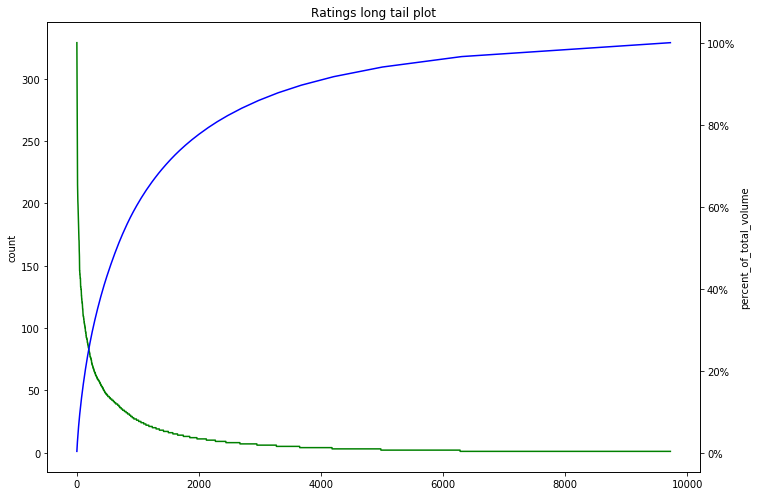

In [47]:
%matplotlib inline
fig, ax2 = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.lineplot(data=df_to_plot['count'], color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_to_plot['percent_of_total_volume'], color="b", ax=ax2)
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_title('Ratings long tail plot')

## Train/Test split

In [49]:
df_ratings = df_ratings.merge(df_movies[['movieId', 'title']],how='left', on='movieId')

In [50]:
train_data, test_data = train_test_split(df_ratings, test_size = 0.25, random_state=57)

In [51]:
test_res = test_data.copy().groupby('userId', as_index=False)['title'].agg({'actual': (lambda x: list(set(x)))})
test_res = test_res.set_index("userId")

In [52]:
test_res

,actual
userId,
1,"[Total Recall (1990), Romancing the Stone (198..."
2,[The Jinx: The Life and Deaths of Robert Durst...
3,[Wallace & Gromit: The Best of Aardman Animati...
4,"[Mr. Mom (1983), American Beauty (1999), I'm t..."
5,"[In the Line of Fire (1993), Ace Ventura: Pet ..."
...,...
606,"[Show Me Love (Fucking Åmål) (1998), Fried Gre..."
607,"[Scream (1996), American Beauty (1999), Fearle..."
608,"[American Beauty (1999), Mighty Wind, A (2003)..."


Create user-item matrix for train and test.

In [53]:
train_data_ui = train_data.pivot_table(index=['userId'], columns=['title'], values='rating')
test_data_ui = test_data.pivot_table(index=['userId'], columns=['title'], values='rating')

In [54]:
train_data_ui

title,'Round Midnight (1986),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),...,Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN


### Simple rating prediction. MSE

Мы сделаем простое предсказание по среднему рейтингу фильма на обучающей выборке.

In [55]:
print("Number of movies in Test: {}".format(len(set(test_data.movieId))))
print("Interseption of movies in Train and Test: {}".format(len(set.intersection(set(test_data.movieId), set(train_data.movieId)))))

Number of movies in Test: 5671
Interseption of movies in Train and Test: 4753


In [56]:
mean_rating = pd.DataFrame(train_data_ui.mean(axis=0), columns=['pred_rating']).reset_index()

In [57]:
mean_rating

,title,pred_rating
0,'Round Midnight (1986),3.500000
1,'Til There Was You (1997),4.000000
2,'Tis the Season for Love (2015),1.500000
3,"'burbs, The (1989)",3.166667
4,'night Mother (1986),3.000000
...,...,...
8797,anohana: The Flower We Saw That Day - The Movi...,3.000000
8798,eXistenZ (1999),3.882353
8799,xXx (2002),2.823529
8800,xXx: State of the Union (2005),2.000000


In [59]:
test_data = test_data.merge(mean_rating, how='left', on='title')

In [60]:
test_data.head()

,userId,movieId,rating,timestamp,title,pred_rating
0,474,2686,3.0,1087832200,"Red Violin, The (Violon rouge, Le) (1998)",4.076923
1,70,1959,4.5,1355184760,Out of Africa (1985),3.500000
2,24,1527,4.0,1458941643,"Fifth Element, The (1997)",3.692308
3,580,172,3.5,1167792949,Johnny Mnemonic (1995),2.714286
4,203,7153,5.0,1390094680,"Lord of the Rings: The Return of the King, The...",4.093985


In [61]:
def mse(actual, pred) -> float:
    """
    Computes the mean square error (MSE)
    Parameters
    ----------
    actual : original true ratings or interaction values.
    y: predicted ratings or interaction values.
    Returns:
    -------
        The mean square error (MSE)
    """
    mse = np.square(np.subtract(actual,pred)).mean() 
    return mse

In [62]:
print("MSE for CF: {:.2}".format(mse(test_data.rating, test_data.pred_rating)))

MSE for CF: 0.95


In [20]:
def rmse(actual, pred) -> float:
    """
    Computes the root mean square error (RMSE)
    Parameters
    ----------
    actual : original true ratings or interaction values.
    y: predicted ratings or interaction values.
    Returns:
    -------
        The root mean square error (RMSE)
    """
    
    ######################
    # WRITE YOUR CODE HERE
    ######################
    
    return rmse

In [ ]:
print("RMSE for CF: {:.2}".format(rmse(test_data.rating, test_data.pred_rating)))

## Train 3 models: Collaborative Filtering (CF), Popularity, Random

### Collaborative filtering based on Pearson similarity

In [63]:
cf_recs = []

In [64]:
%%time
corr_matrix = train_data_ui.corr(method='pearson', min_periods=100)

CPU times: user 25.1 s, sys: 943 ms, total: 26 s
Wall time: 31.8 s


In [ ]:
corr_matrix

In [65]:
%%time
for i in test_res.index:
    user_ratings = train_data_ui.loc[i].dropna()
    simCandidates = pd.Series()

    for j in range(0, len(user_ratings.index)): # Идем по списку всех фильмов оцененных пользвателем
        sims = corr_matrix[user_ratings.index[j]].dropna() # Извлекаем фильмы, похожие на оцененные данным юзером (1)
        sims = sims.map(lambda x: x * user_ratings[j]) # Умножаем корреляцию на оценку пользователя по фильму
        simCandidates = simCandidates.append(sims) # Добавляем индекс в список сравниваемых кандидатов

    simCandidates = simCandidates.groupby(simCandidates.index).sum()
    simCandidates.sort_values(inplace = True, ascending = False)

    # выбираем фильмы, которые пользователь еще не смотрел
    intersection_set = set.intersection(set(simCandidates.index), set(user_ratings.index))
    not_watched = list(set(simCandidates.index) - set(user_ratings.index))
    colab_predictions = simCandidates[not_watched].sort_values(ascending = False).head(10).index.to_list()
    cf_recs.append(colab_predictions)

CPU times: user 1min 21s, sys: 2.03 s, total: 1min 23s
Wall time: 1min 52s


In [66]:
test_res['colab_predictions'] = cf_recs
test_res.head()

,actual,colab_predictions
userId,,
1,"[Total Recall (1990), Romancing the Stone (198...","[Shawshank Redemption, The (1994), Pulp Fictio..."
2,[The Jinx: The Life and Deaths of Robert Durst...,"[Braveheart (1995), Forrest Gump (1994), Fight..."
3,[Wallace & Gromit: The Best of Aardman Animati...,[]
4,"[Mr. Mom (1983), American Beauty (1999), I'm t...","[Shawshank Redemption, The (1994), Forrest Gum..."
5,"[In the Line of Fire (1993), Ace Ventura: Pet ...","[Forrest Gump (1994), Matrix, The (1999), Sile..."


#### Popularity recommender

In [67]:
#make recommendations for all members in the test data
popularity_recs = train_data.title.value_counts().head(10).index.tolist()

pop_recs = []
for user in test_res.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test_res['pop_predictions'] = pop_recs
test_res.head()

,actual,colab_predictions,pop_predictions
userId,,,
1,"[Total Recall (1990), Romancing the Stone (198...","[Shawshank Redemption, The (1994), Pulp Fictio...","[Forrest Gump (1994), Shawshank Redemption, Th..."
2,[The Jinx: The Life and Deaths of Robert Durst...,"[Braveheart (1995), Forrest Gump (1994), Fight...","[Forrest Gump (1994), Shawshank Redemption, Th..."
3,[Wallace & Gromit: The Best of Aardman Animati...,[],"[Forrest Gump (1994), Shawshank Redemption, Th..."
4,"[Mr. Mom (1983), American Beauty (1999), I'm t...","[Shawshank Redemption, The (1994), Forrest Gum...","[Forrest Gump (1994), Shawshank Redemption, Th..."
5,"[In the Line of Fire (1993), Ace Ventura: Pet ...","[Forrest Gump (1994), Matrix, The (1999), Sile...","[Forrest Gump (1994), Shawshank Redemption, Th..."


#### Random recommender

In [68]:
#make recommendations for all members in the test data

ran_recs = []
for user in test_res.index:
    random_predictions = df_ratings.title.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test_res['rand_predictions'] = ran_recs
test_res.head()

,actual,colab_predictions,pop_predictions,rand_predictions
userId,,,,
1,"[Total Recall (1990), Romancing the Stone (198...","[Shawshank Redemption, The (1994), Pulp Fictio...","[Forrest Gump (1994), Shawshank Redemption, Th...","[Titanic (1997), Igby Goes Down (2002), Americ..."
2,[The Jinx: The Life and Deaths of Robert Durst...,"[Braveheart (1995), Forrest Gump (1994), Fight...","[Forrest Gump (1994), Shawshank Redemption, Th...","[Bolt (2008), Man with Two Brains, The (1983),..."
3,[Wallace & Gromit: The Best of Aardman Animati...,[],"[Forrest Gump (1994), Shawshank Redemption, Th...","[Hangover Part III, The (2013), Beowulf (2007)..."
4,"[Mr. Mom (1983), American Beauty (1999), I'm t...","[Shawshank Redemption, The (1994), Forrest Gum...","[Forrest Gump (1994), Shawshank Redemption, Th...","[How to Train Your Dragon (2010), Apollo 13 (1..."
5,"[In the Line of Fire (1993), Ace Ventura: Pet ...","[Forrest Gump (1994), Matrix, The (1999), Sile...","[Forrest Gump (1994), Shawshank Redemption, Th...",[Star Wars: Episode V - The Empire Strikes Bac...


## Let's check quality

### Catalog Coverage

In [70]:
def catalog_coverage(predicted, catalog, k: int) -> float:
    '''
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    '''
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0),3)
    return catalog_coverage

In [71]:
catalog = df_ratings.title.unique().tolist()
cf_cat_coverage = catalog_coverage(cf_recs, catalog, 100)
pop_cat_coverage = catalog_coverage(pop_recs, catalog, 100)
random_cat_coverage = catalog_coverage(ran_recs, catalog, 100)

In [72]:
print("Catalog coverage (cf): {}".format(cf_cat_coverage))
print("Catalog coverage (popular): {}".format(pop_cat_coverage))
print("Catalog coverage (random): {}".format(random_cat_coverage))

Catalog coverage (cf): 0.001
Catalog coverage (popular): 0.001
Catalog coverage (random): 0.076


### User coverage

In [35]:
def user_coverage(predicted) -> float:
    """
    Computes the share of test users to whom we were able to provide recommendation.
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns
    ----------
    user_coverage:
        Share of test users in predicted list to whom we provided recommendation
        rounded to 2 decimal places
    """
    
    ######################
    # WRITE YOUR CODE HERE
    ######################
    
    return user_coverage

In [ ]:
print("User coverage (cf): {}".format(user_coverage(cf_recs)))
print("User coverage (popular): {}".format(user_coverage(pop_recs)))
print("User coverage (random): {}".format(user_coverage(ran_recs)))

### Novelty

In [74]:
def novelty(predicted, pop, u: int, n: int) -> (float, list):
    """
    Computes the novelty for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
    pop: dictionary
        A dictionary of all items alongside of its occurrences counter in the training data
        example: {1198: 893, 1270: 876, 593: 876, 2762: 867}
    u: integer
        The number of users in the training data
    n: integer
        The length of recommended lists per user
    Returns
    ----------
    novelty:
        The novelty of the recommendations in system level
    mean_self_information:
        The novelty of the recommendations in recommended top-N list level
    ----------
    Metric definition: https://arxiv.org/pdf/0808.2670.pdf
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information

In [76]:
nov = df_ratings.title.value_counts()
pop = dict(nov)
users = df_ratings["userId"].value_counts()

In [77]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)

In [78]:
print("Novelty (cf): {}".format(cf_novelty))
print("Novelty (popular): {}".format(pop_novelty))
print("Novelty (random): {}".format(random_novelty))

Novelty (cf): 0.5083075101278091
Novelty (popular): 1.2020570477713304
Novelty (random): 4.33739270607073


### Hitrate@k

Напомним, что это сколько верных рекомендаций мы предложили пользователю u на заданном количестве рекомендаций.

In [186]:
def hitrate_k(predicted, actual, k: int) -> int:
    """
    Computes the average number of correct reccommendations for a user
    Parameters
    ----------
    predicted : a list of lists with recommendations
    actual: list of lists with actual movie watches
    k: integer
        The maximum number of recommendations in a list
    Returns
    ----------
    hitrate_k:
        The average number of correct recommendations for a user
    """
    
    ######################
    # WRITE YOUR CODE HERE
    ######################
    
    return hitrate_k

In [189]:
cf_hitrate_k = hitrate_k(test_res.colab_predictions, test_res.actual, 10)
pop_hitrate_k = hitrate_k(test_res.pop_predictions, test_res.actual, 10)
random_hitrate_k = hitrate_k(test_res.rand_predictions, test_res.actual, 10)

In [ ]:
print("Hitrate_k (cf): {}".format(cf_hitrate_k))
print("Hitrate_k (popular): {}".format(pop_hitrate_k))
print("Hitrate_k (random): {}".format(random_hitrate_k))